# Uncertainty Estimation

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import numpy as np
import xarray as xr

from hython.datasets import Wflow1d
from hython.trainer import train_val, RNNTrainer
from hython.sampler import SamplerBuilder
from hython.io import read_from_zarr
from hython.utils import set_seed
from hython.models.cudnnLSTM import CuDNNLSTM
from hython.scaler import Scaler

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt

from hython.viz import show_train_val_curve

from omegaconf import OmegaConf
from hydra.utils import instantiate

from hython.evaluator import predict

from hython.uncertainty import monte_carlo_dropout
from hython.uncertainty import conformal_quantile_regression

from hython.utils import prepare_for_plotting1d

from hython.io import read_from_zarr


from hython.losses import PinballLoss, NegLLLoss, RMSELoss

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = instantiate(OmegaConf.load("./uncertainty_config.yaml"))
set_seed(cfg.seed)

scaler = Scaler(cfg)

train_dataset = Wflow1d(cfg, scaler, True, "train" )
val_dataset = Wflow1d(cfg, scaler, False, "valid")
test_dataset = Wflow1d(cfg, scaler, False, "test")

train_sampler = SamplerBuilder(
    train_dataset, sampling="random", processing="single-gpu"
).get_sampler()

val_sampler  = SamplerBuilder(
    val_dataset, sampling="sequential", processing="single-gpu"
).get_sampler()

test_sampler  = SamplerBuilder(
    test_dataset, sampling="sequential", processing="single-gpu"
).get_sampler()


train_loader = DataLoader(train_dataset, batch_size=cfg.batch, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch, sampler=test_sampler)

Data statistics saved to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty


In [15]:
y_target = test_dataset.y.values
lat, lon, time = len(test_dataset.xs.unstack().lat),len(test_dataset.xs.unstack().lon), len(test_dataset.xd.unstack().time)
coords = test_dataset.y.unstack().isel(feat=0).coords
lat,lon, time

(180, 223, 731)

In [16]:
y_target_plot = prepare_for_plotting1d(y_target, shape = (lat, lon, time), coords = coords, reverse_lat=True)

(180, 223, 731)


# Probabilistic Output

In [17]:
cfg.model_file_name = "prob.pt"

cfg.loss_fn = NegLLLoss() 

cfg.model_head_layer = "distr_normal"
cfg.model_head_activation = "linear"
cfg.model_head_kwargs = {"hidden_dim":32, "n_layers":2}

In [18]:
model = CuDNNLSTM(
    hidden_size=cfg.hidden_size,
    dynamic_input_size=len(cfg.dynamic_inputs),
    static_input_size=len(cfg.static_inputs),
    output_size=len(cfg.target_variables),
    dropout=cfg.dropout,
    head_layer=cfg.model_head_layer,
    head_activation=cfg.model_head_activation,
    head_kwargs= cfg.model_head_kwargs if cfg.model_head_kwargs is not None else {}
)

model.to(device)

trainer = RNNTrainer(
    cfg
)

model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    val_loader,
    cfg.epochs,
    device,
)

Run directory: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty
Model path: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty/prob.pt


  0%|          | 0/3 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty/prob.pt
Copied best model weights!
Losses - train: -0.082914  val: -0.427121
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty/prob.pt
Copied best model weights!
Losses - train: -0.453886  val: -0.499062
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_uncertainty/prob.pt
Copied best model weights!
Losses - train: -0.527313  val: -0.601413


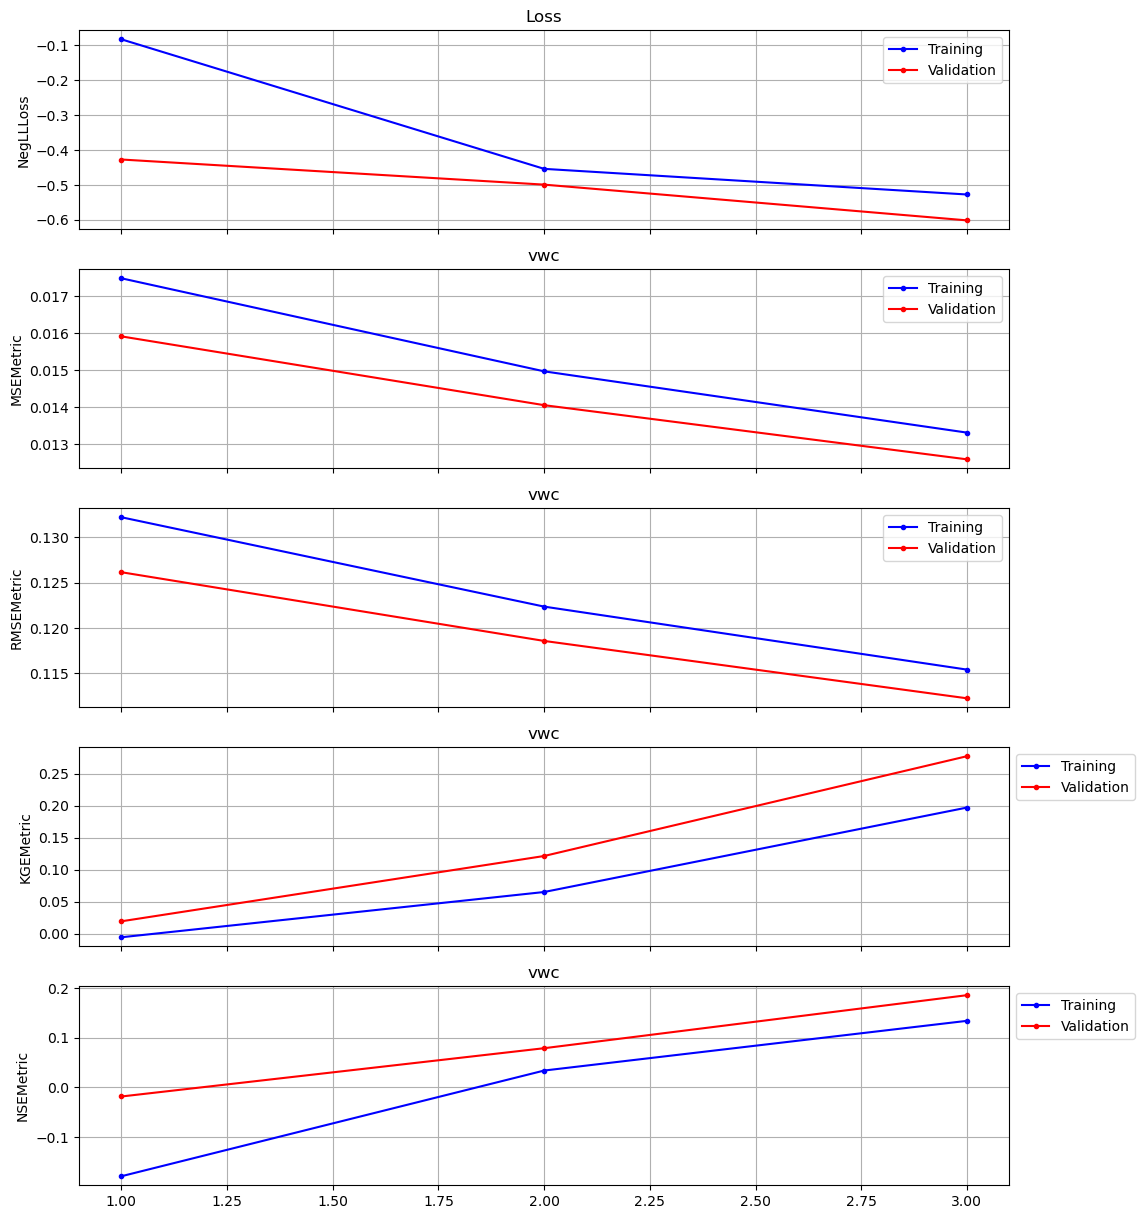

In [19]:
show_train_val_curve(cfg.epochs, cfg.target_variables, cfg.loss_fn.__class__.__name__, loss_history, metric_history);

In [20]:
model.load_state_dict(torch.load(f"{scaler.run_dir}/{cfg.model_file_name}"))

<All keys matched successfully>

In [21]:
y_mu = predict(test_dataset, model, cfg.batch, device, target="mu")
y_sigma = predict(test_dataset, model, cfg.batch, device, target="sigma")

In [22]:
y_mu_plot = prepare_for_plotting1d(y_mu, shape = (lat, lon, time), coords = coords, reverse_lat=True)
y_sigma_plot = prepare_for_plotting1d(y_sigma, shape = (lat, lon, time), coords = coords, reverse_lat=True)

(180, 223, 731)
(180, 223, 731)


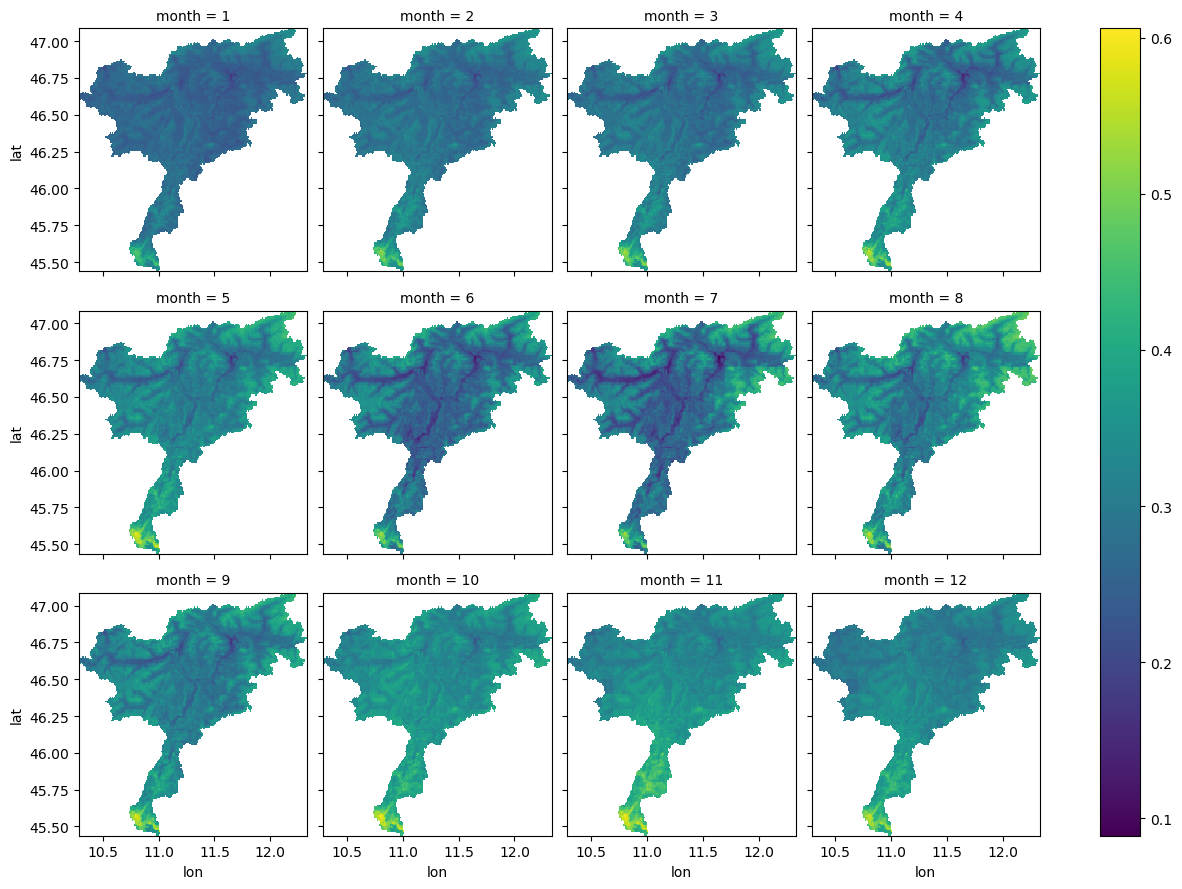

In [23]:
y_mu_plot.groupby("time.month").mean().plot(col="month", col_wrap=4)

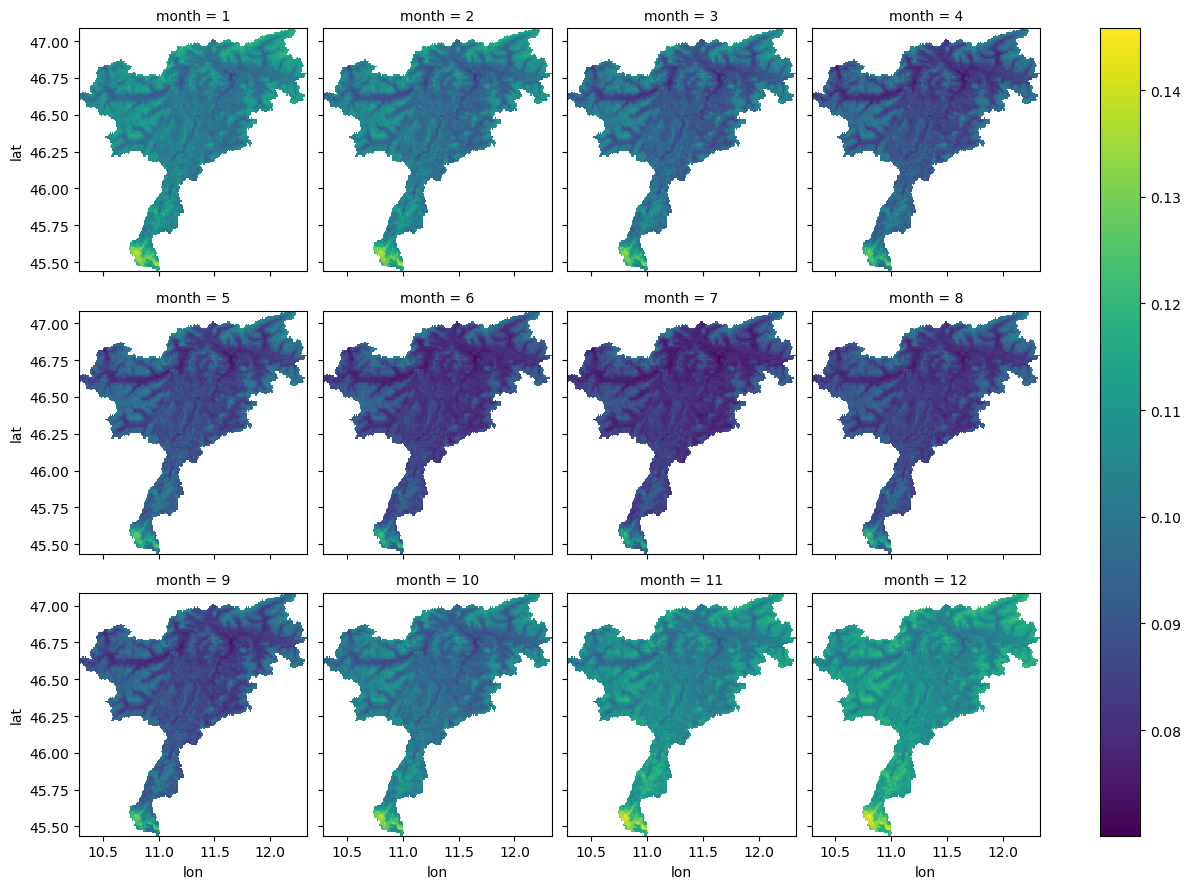

In [24]:
y_sigma_plot.groupby("time.month").mean().plot(col="month", col_wrap=4)

# Dropout

In [160]:
cfg.model_file_name = "dropout_01.pt"

cfg.dropout = 0.1

cfg.loss_fn = RMSELoss()

cfg.model_head_layer = "regression"
cfg.model_head_activation = "linear"
cfg.model_head_kwargs = None

In [161]:
model = CuDNNLSTM(
    hidden_size=cfg.hidden_size,
    dynamic_input_size=len(cfg.dynamic_inputs),
    static_input_size=len(cfg.static_inputs),
    output_size=len(cfg.target_variables),
    dropout=cfg.dropout,
    head_layer=cfg.model_head_layer,
    head_activation=cfg.model_head_activation,
    head_kwargs= cfg.model_head_kwargs if cfg.model_head_kwargs is not None else {}
)

model.to(device)

CuDNNLSTM(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc0): Linear(in_features=6, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (head): RegressionHead(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=False)
    )
  )
)

In [62]:
trainer = RNNTrainer(
    cfg
)

model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    val_loader,
    cfg.epochs,
    device,
)

Run directory: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic
Model path: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_01.pt


  0%|          | 0/3 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_01.pt
Copied best model weights!
Losses - train: 0.065452  val: 0.060427
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_01.pt
Copied best model weights!
Losses - train: 0.050914  val: 0.043228
Losses - train: 0.044922  val: 0.047929


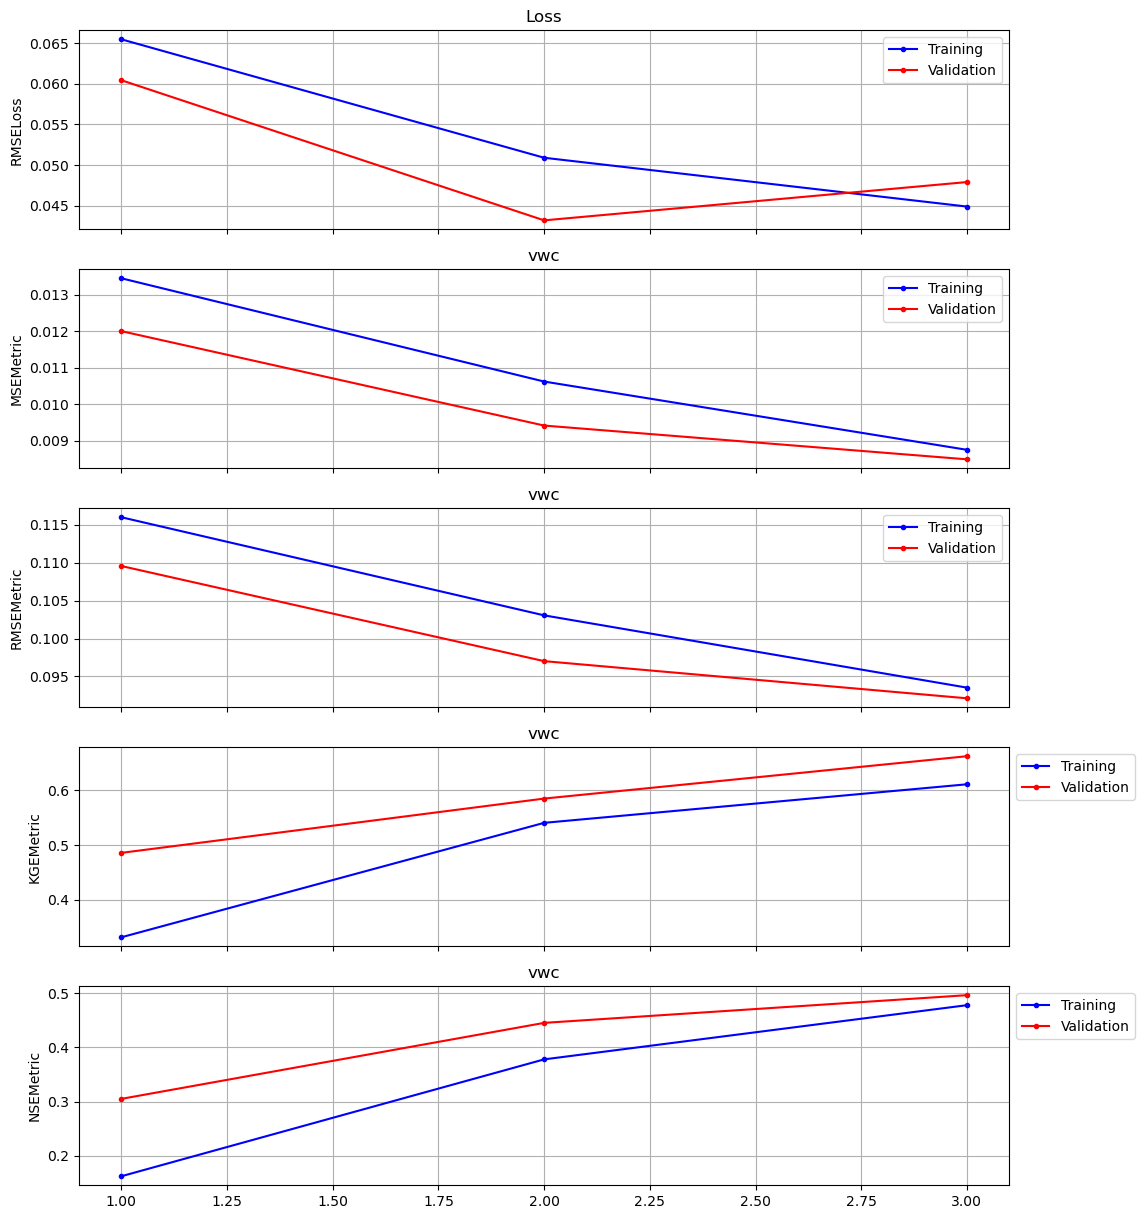

In [63]:
show_train_val_curve(cfg.epochs, cfg.target_variables, cfg.loss_fn.__class__.__name__, loss_history, metric_history);

In [162]:
cfg.model_file_name = "dropout_05.pt"

cfg.dropout = 0.5


In [163]:
model = CuDNNLSTM(
    hidden_size=cfg.hidden_size,
    dynamic_input_size=len(cfg.dynamic_inputs),
    static_input_size=len(cfg.static_inputs),
    output_size=len(cfg.target_variables),
    dropout=cfg.dropout,
    head_layer=cfg.model_head_layer,
    head_activation=cfg.model_head_activation,
    head_kwargs= cfg.model_head_kwargs if cfg.model_head_kwargs is not None else {}
)

model.to(device)

CuDNNLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (fc0): Linear(in_features=6, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (head): RegressionHead(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=False)
    )
  )
)

In [ ]:
trainer = RNNTrainer(
    cfg
)

model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    val_loader,
    cfg.epochs,
    device,
)

Run directory: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic
Model path: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_05.pt


  0%|          | 0/3 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_05.pt
Copied best model weights!
Losses - train: 0.068505  val: 0.058179
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_05.pt
Copied best model weights!
Losses - train: 0.060468  val: 0.051052
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/dropout_05.pt
Copied best model weights!
Losses - train: 0.054692  val: 0.045074


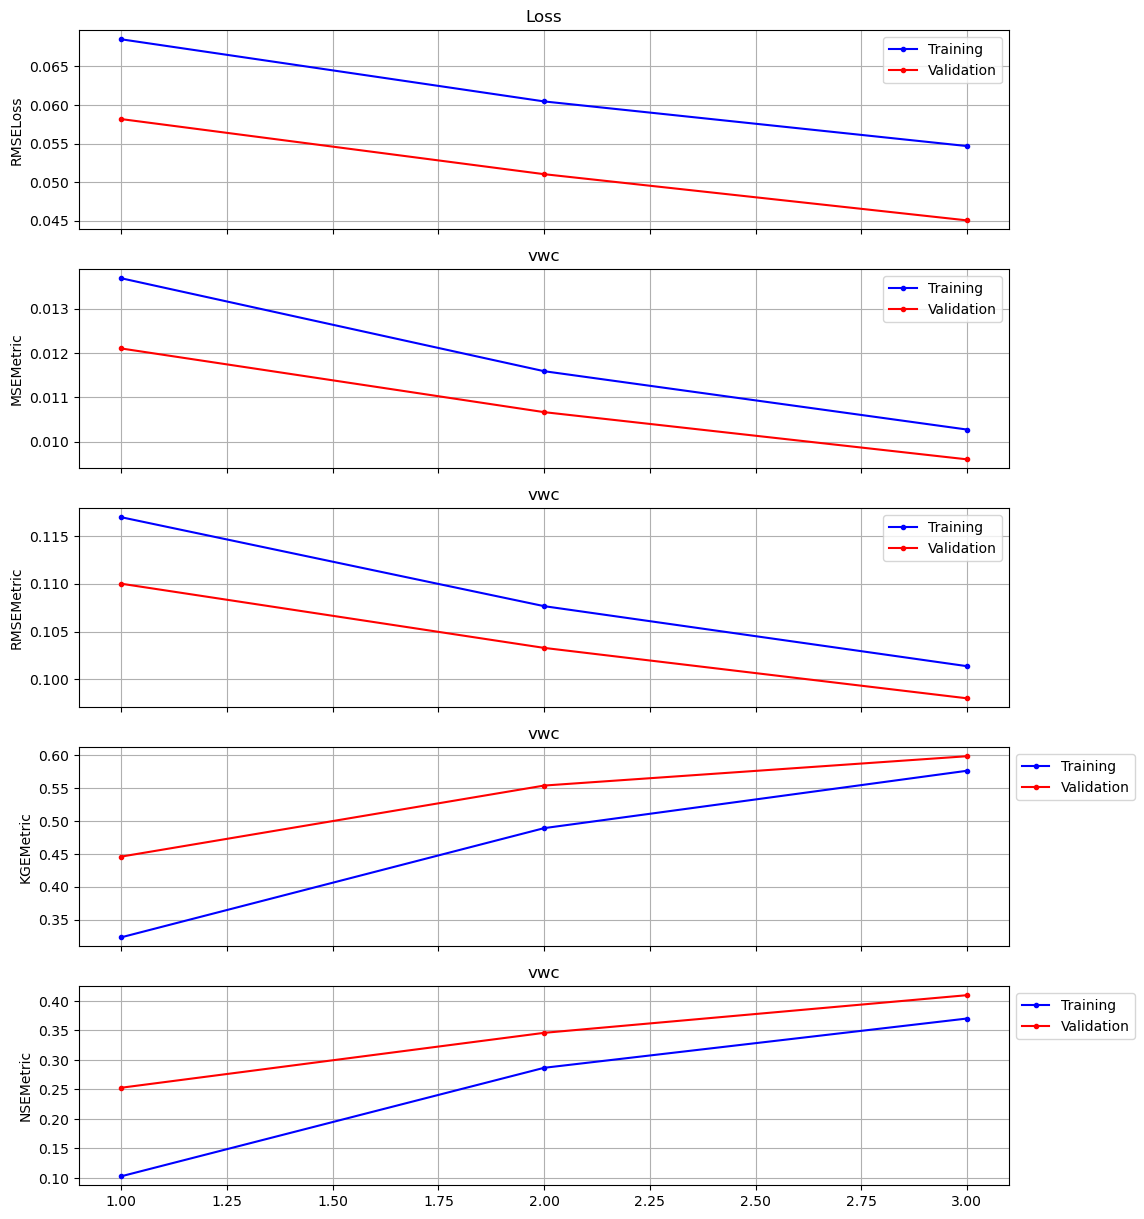

In [66]:
show_train_val_curve(cfg.epochs, cfg.target_variables, cfg.loss_fn.__class__.__name__, loss_history, metric_history);

In [164]:
model.load_state_dict(torch.load(f"{scaler.run_dir}/dropout_01.pt"))

<All keys matched successfully>

In [165]:
mean_mcd01, std_mcd01 = monte_carlo_dropout(model, test_dataset, cfg.batch, n_samples=10, steps="all", device=device)

In [166]:
model.load_state_dict(torch.load(f"{scaler.run_dir}/dropout_05.pt"))

<All keys matched successfully>

In [167]:
mean_mcd05, std_mcd05 = monte_carlo_dropout(model, test_dataset, cfg.batch, n_samples=10, steps="all", device=device)

In [169]:
mcd_mean_plot05 = prepare_for_plotting1d(mean_mcd05, shape = (lat, lon, time), coords = coords, reverse_lat=True)
mcd_std_plot05 = prepare_for_plotting1d(std_mcd05, shape = (lat, lon, time), coords = coords, reverse_lat=True)

(180, 223, 731)
(180, 223, 731)


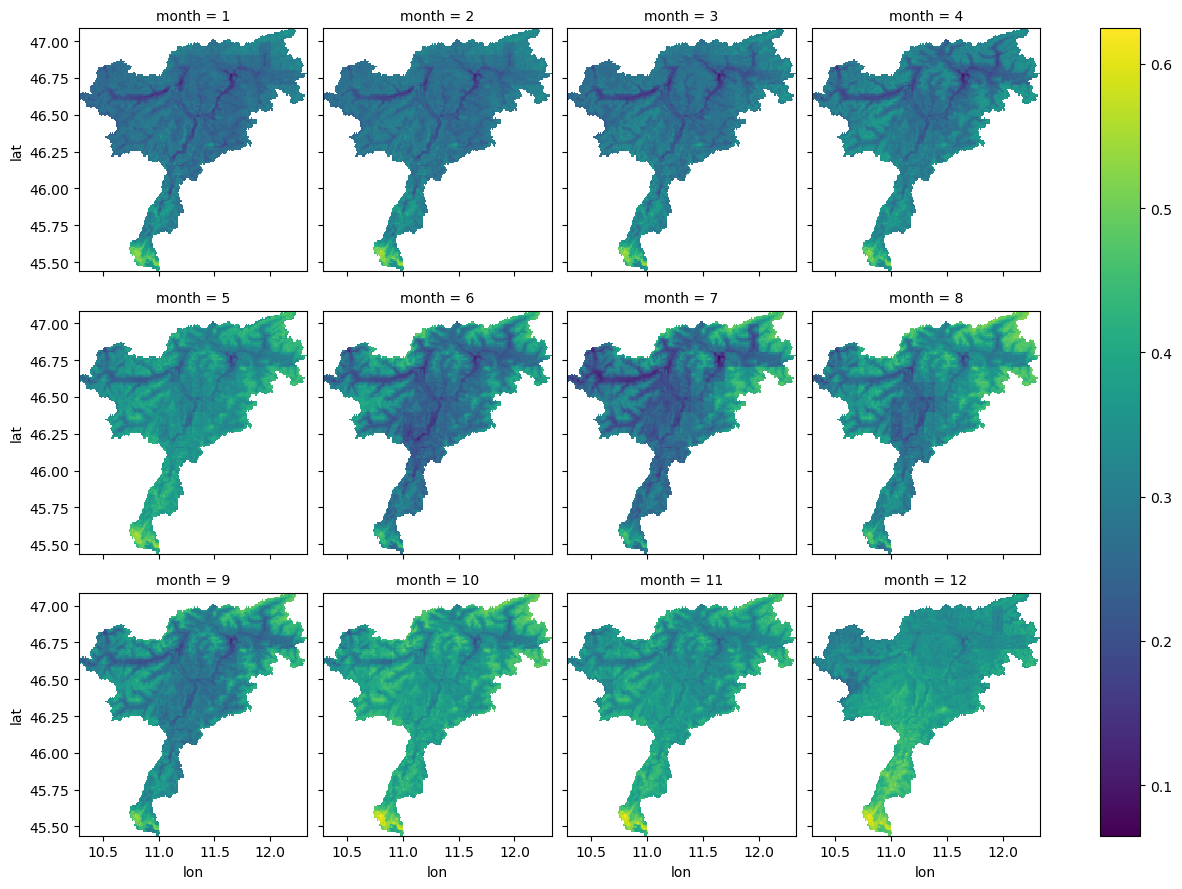

In [170]:
mcd_mean_plot05.groupby("time.month").mean().plot(col="month", col_wrap=4)

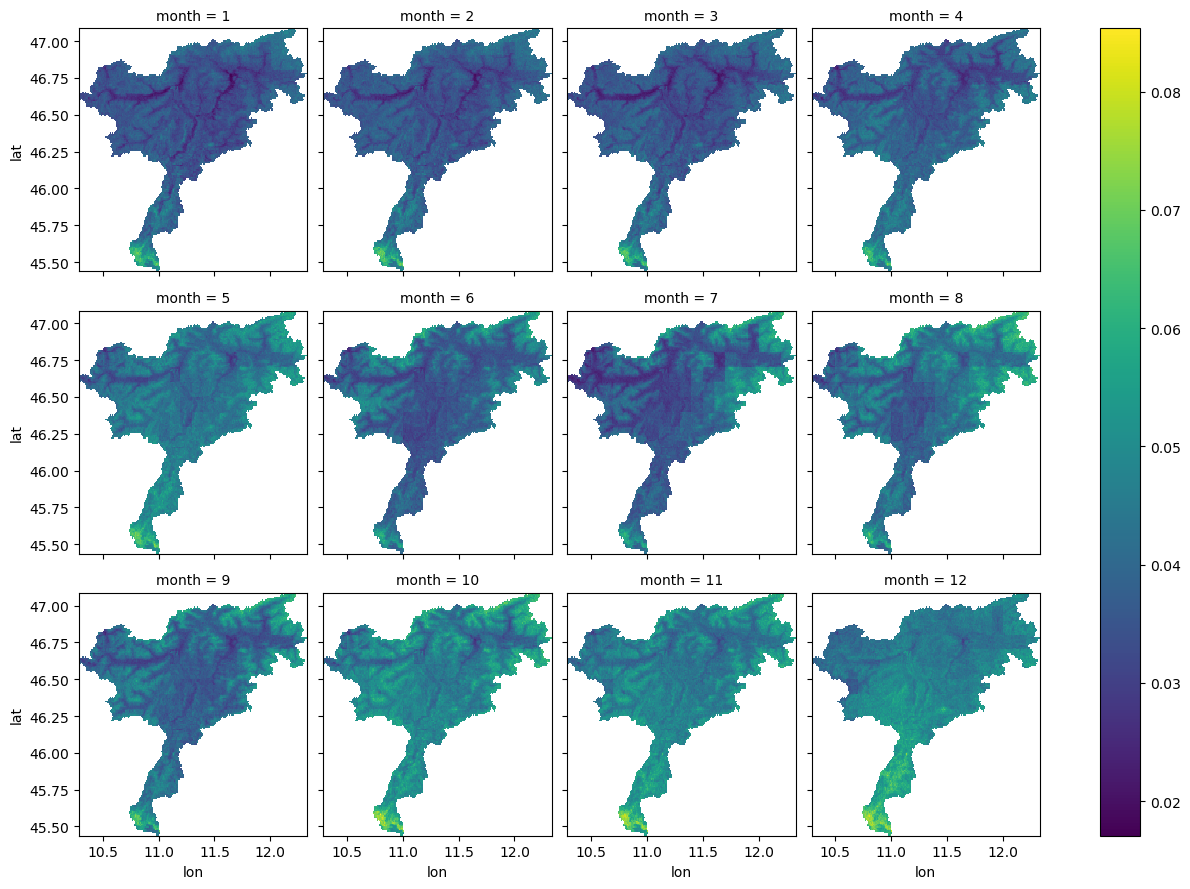

In [171]:
mcd_std_plot05.groupby("time.month").mean().plot(col="month", col_wrap=4)

# Conformal

In [172]:
cfg.model_file_name = "conformal_10.pt"

cfg.dropout = 0.1

cfg.loss_fn = PinballLoss(tau=0.1)

cfg.model_head_layer = "regression"
cfg.model_head_activation = "linear"
cfg.model_head_kwargs = None

In [101]:
model = CuDNNLSTM(
    hidden_size=cfg.hidden_size,
    dynamic_input_size=len(cfg.dynamic_inputs),
    static_input_size=len(cfg.static_inputs),
    output_size=len(cfg.target_variables),
    dropout=cfg.dropout,
    head_layer=cfg.model_head_layer,
    head_activation=cfg.model_head_activation,
    head_kwargs= cfg.model_head_kwargs if cfg.model_head_kwargs is not None else {}
)

model.to(device)

trainer = RNNTrainer(
    cfg
)

model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    val_loader,
    cfg.epochs,
    device,
)

Run directory: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic
Model path: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_10.pt


  0%|          | 0/3 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_10.pt
Copied best model weights!
Losses - train: 0.011843  val: 0.010817
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_10.pt
Copied best model weights!
Losses - train: 0.009703  val: 0.009141
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_10.pt
Copied best model weights!
Losses - train: 0.008073  val: 0.006567


In [102]:
cfg.model_file_name = "conformal_90.pt"
cfg.loss_fn = PinballLoss(tau=0.9)


In [103]:
model = CuDNNLSTM(
    hidden_size=cfg.hidden_size,
    dynamic_input_size=len(cfg.dynamic_inputs),
    static_input_size=len(cfg.static_inputs),
    output_size=len(cfg.target_variables),
    dropout=cfg.dropout,
    head_layer=cfg.model_head_layer,
    head_activation=cfg.model_head_activation,
    head_kwargs= cfg.model_head_kwargs if cfg.model_head_kwargs is not None else {}
)

model.to(device)

trainer = RNNTrainer(
    cfg
)

model, loss_history, metric_history = train_val(
    trainer,
    model,
    train_loader,
    val_loader,
    cfg.epochs,
    device,
)

Run directory: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic
Model path: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_90.pt


  0%|          | 0/3 [00:00<?, ?it/s]

save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_90.pt
Copied best model weights!
Losses - train: 0.011702  val: 0.009988
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_90.pt
Copied best model weights!
Losses - train: 0.009784  val: 0.009566
save weights to: /mnt/CEPH_PROJECTS/InterTwin/hython_model_run/lstm_probabilistic/conformal_90.pt
Copied best model weights!
Losses - train: 0.008502  val: 0.009426


In [173]:
model_paths = {
    "q10":f"{scaler.run_dir}/conformal_10.pt",
    "q90":f"{scaler.run_dir}/conformal_90.pt"
}

In [ ]:
emp_cov, median_pred = conformal_quantile_regression(model, 
                                  model_paths, 
                                  cal_dataset=val_dataset, 
                                  test_dataset=test_dataset, 
                                  batch_size=cfg.batch, 
                                  scaler = scaler,
                                  coverages = [0.1, 0.8, 0.9],
                                  steps="all",
                                  target = "y_hat",
                                  device=device)

In [175]:
median_pred_plot = prepare_for_plotting1d(median_pred, shape = (lat, lon, time), coords = coords, reverse_lat=True)

(180, 223, 731)


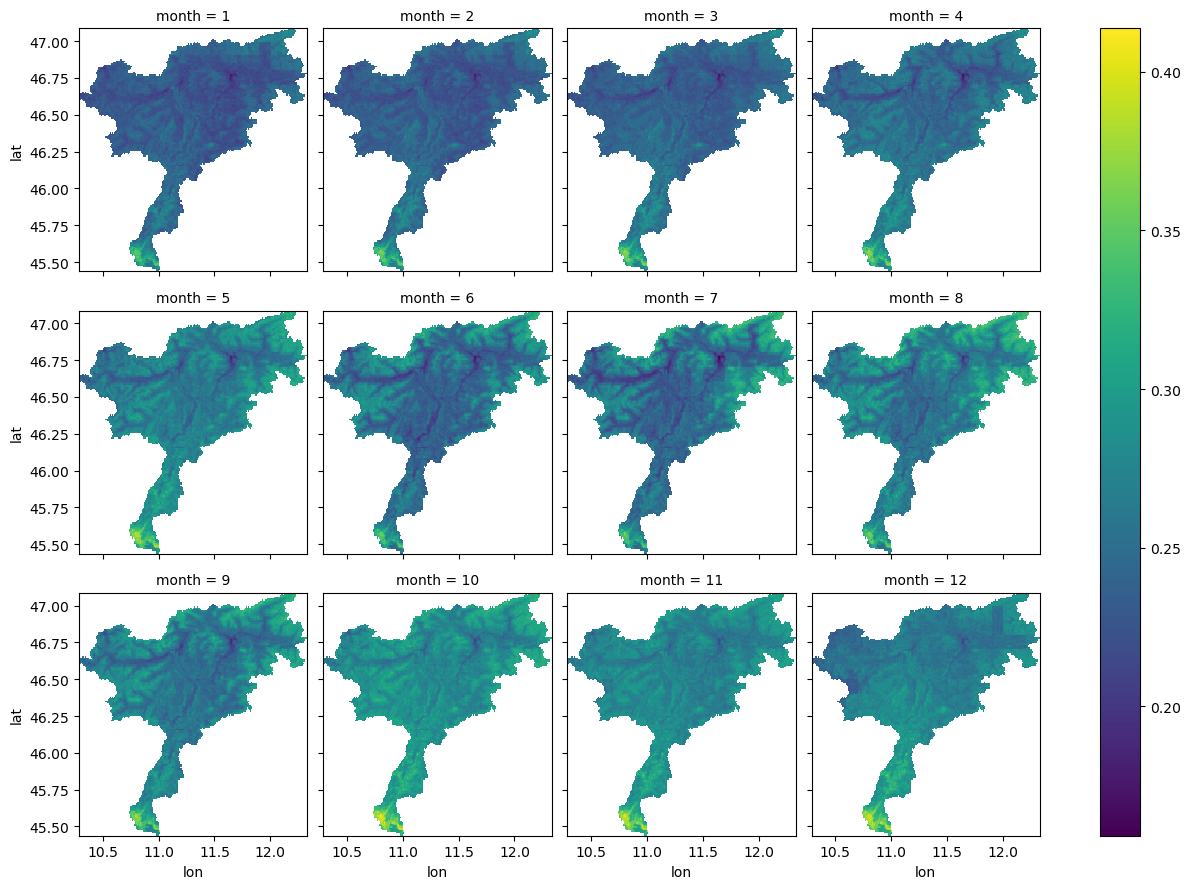

In [176]:
median_pred_plot.groupby("time.month").mean().plot(col="month", col_wrap=4)